In [1]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
from skimage import io
from skimage import color
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline 

In [77]:
MAIN_PATH = "/Users/ekaterina/Documents/Semantic Segmentation/ISPRS_semantic_labeling_Vaihingen" dsm_09cm_matching_area1

#rfc
TREES_NUM = 100
JOBS_NUM = 4

#data
TEST_PICS = {15}
#TEST_PICS = {1,7,10,12,15} #ideal_ones

LABELED_PICS = {37,34}
#LABELED_PICS = {1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37} #ideal_ones

In [14]:
def get_rgb_pic(num):
    rgb_path = MAIN_PATH + "/top/top_mosaic_09cm_area{}.tif". format(num)
    res = plt.imread(rgb_path)
    return res

In [15]:
def get_label_pic(num):
    label_path = MAIN_PATH + "/gts_for_participants/top_mosaic_09cm_area{}.tif". format(num)
    res = plt.imread(label_path)
    return res

In [5]:
def show_pic(pic):
    plt.imshow(pic)
    plt.show()

In [17]:
def get_hsv(image):
    return color.rgb2hsv(image)

In [18]:
def get_lab(image):
    return color.rgb2lab(image)

In [8]:
def combine_features(source1, source2, source3):
    data = np.zeros((source1.shape[0],source1.shape[1], 9), dtype = 'float64')
    for i in range(source1.shape[0]):
        for j in range (source1.shape[1]):
            data[i][j][0:3] = source1[i][j][:]
            data[i][j][3:6] = source2[i][j][:]
            data[i][j][6:9] = source3[i][j][:]
    return data

In [9]:
def make_data_plain(data, features_num):
    plain_data = data.copy()
    plain_data.resize(data.shape[0]*data.shape[1], features_num)
    return plain_data

In [35]:
def convert_color_to_labels(color_map):
    categories = np.zeros((6, 3), dtype = 'uint8')
    categories[0]  = [255, 255, 255]
    categories[1]  = [0, 0, 255]
    categories[2]  = [0, 255, 255]
    categories[3]  = [0, 255, 0]
    categories[4]  = [255, 255, 0]
    categories[5]  = [255, 0, 0]

    label_map = np.zeros((color_map.shape[0],color_map.shape[1]), dtype = 'uint8')
    for i in range(color_map.shape[0]):
        for j in range (color_map.shape[1]):
            pics = color_map[i][j][:]
            for k in range(6):
                if (pics[0] == categories[k][0]) and (pics[1] == categories[k][1]) and (pics[2] == categories[k][2]):
                    label_map[i][j] = k
                    break
    
    return label_map

In [37]:
def convert_plain_color_to_labels(color_map):
    categories = np.zeros((6, 3), dtype = 'uint8')
    categories[0]  = [255, 255, 255]
    categories[1]  = [0, 0, 255]
    categories[2]  = [0, 255, 255]
    categories[3]  = [0, 255, 0]
    categories[4]  = [255, 255, 0]
    categories[5]  = [255, 0, 0]

    label_map = np.zeros((color_map.shape[0]), dtype = 'uint8')
    for i in range(color_map.shape[0]):
        pics = color_map[i][:]
        for k in range(6):
            if (pics[0] == categories[k][0]) and (pics[1] == categories[k][1]) and (pics[2] == categories[k][2]):
                label_map[i] = k
                break
    
    return label_map

In [11]:
def convert_labels_to_color(label_map):
    categories = np.zeros((6, 3), dtype = 'uint8')
    categories[0]  = [255, 255, 255]
    categories[1]  = [0, 0, 255]
    categories[2]  = [0, 255, 255]
    categories[3]  = [0, 255, 0]
    categories[4]  = [255, 255, 0]
    categories[5]  = [255, 0, 0]

    color_map = np.zeros((label_map.shape[0],label_map.shape[1], 3), dtype = 'uint8')
    for i in range(label_map.shape[0]):
        for j in range (label_map.shape[1]):
            for k in range(6):
                if label_map[i][j] == k:
                    color_map[i][j] = categories[k]
                    #color_map[0] == categories[k][0]
                    #color_map[1] == categories[k][1]
                    #color_map[2] == categories[k][2]
                    break
                    
    return color_map

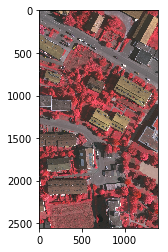

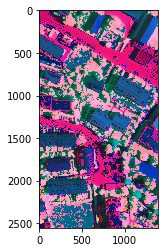

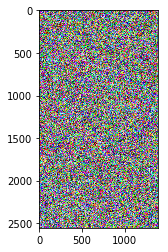

(3546340, 9)


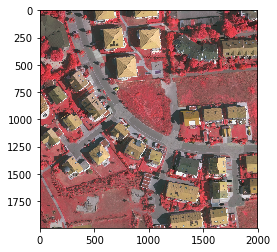

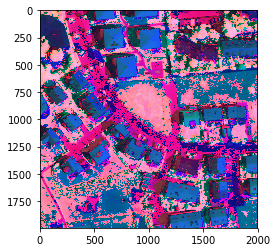

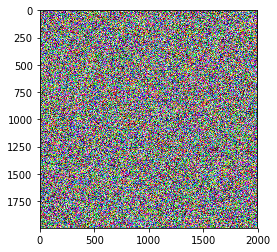

(7528360, 9)
(7528360, 9) (7528360,)


In [43]:
#get train data

train_data = np.zeros((0,9), dtype = 'float64')
label_train_data = np.zeros((0,3), dtype = 'float64')

for ind in LABELED_PICS:
    if not (ind in TEST_PICS):
        cur_rgb = get_rgb_pic(ind)
        show_pic(cur_rgb)
        cur_hsv = get_hsv(cur_rgb)
        show_pic(cur_hsv)
        cur_lab = get_lab(cur_rgb)
        show_pic(cur_lab)
        train_data = np.concatenate((train_data, make_data_plain(combine_features(cur_rgb, cur_hsv, cur_lab),9)))
        print(train_data.shape)
        label_train_data = np.concatenate((label_train_data,make_data_plain(get_label_pic(ind),3)))
train_label_map = convert_plain_color_to_labels(label_train_data)

print(train_data.shape, train_label_map.shape)

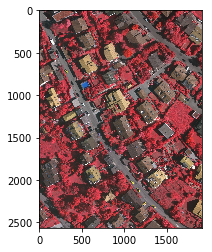

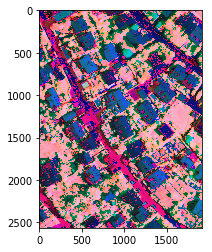

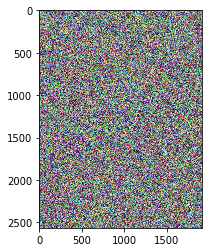

(4922235, 9)
(4922235, 9) (4922235,)


In [78]:
#get test data

test_data = np.zeros((0,9), dtype = 'float64')
label_test_data = np.zeros((0,3), dtype = 'float64')

for ind in TEST_PICS:
    cur_rgb = get_rgb_pic(ind)
    show_pic(cur_rgb)
    cur_hsv = get_hsv(cur_rgb)
    show_pic(cur_hsv)
    cur_lab = get_lab(cur_rgb)
    show_pic(cur_lab)
    test_data = np.concatenate((test_data, make_data_plain(combine_features(cur_rgb, cur_hsv, cur_lab),9)))
    print(test_data.shape)
    label_test_data = np.concatenate((label_test_data,make_data_plain(get_label_pic(ind),3)))
test_label_map = convert_plain_color_to_labels(label_test_data)

print(test_data.shape, test_label_map.shape)

In [48]:
clf = RandomForestClassifier(n_estimators=TREES_NUM, n_jobs = JOBS_NUM)

In [51]:
import time

In [52]:
start_time = time.clock()
print(start_time)
clf.fit(train_data, train_label_map)
finish_time = time.clock()
print(finish_time - start_time)

877.948096
6324.701503


In [54]:
predicted_plain_labels = clf.predict(test_data)

In [56]:
predicted_labels = predicted_plain_labels.copy()
predicted_labels.resize(cur_lab.shape[0],cur_lab.shape[1])

In [57]:
predicted_pic = convert_labels_to_color(predicted_labels)

In [58]:
io.imsave("Predicted labels for %d.jpg" %(ind), predicted_pic)

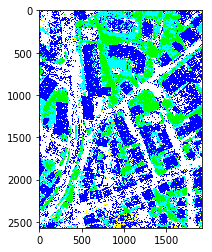

In [59]:
#результат для 1 снимка
show_pic(predicted_pic)

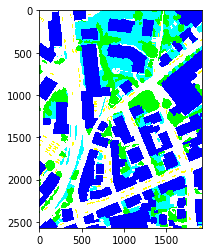

In [60]:
#ground truth для 1 снимка
show_pic(get_label_pic(ind))

In [63]:
from sklearn.metrics import f1_score

In [68]:
test_label_map.shape

(4929911,)

In [69]:
predicted_plain_labels.shape

(4929911,)

In [73]:
f1_score(test_label_map, predicted_plain_labels, labels = [0,1,2,3,4,5,6], average = 'micro')

0.66238863135663095

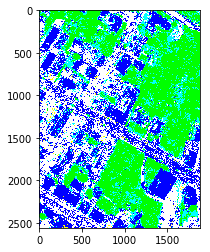

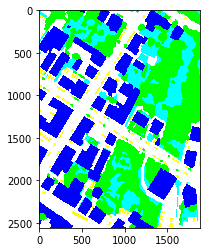

0.63931156074982709

In [76]:
#prediction for 7th area
predicted_plain_labels = clf.predict(test_data)
predicted_labels = predicted_plain_labels.copy()
predicted_labels.resize(cur_lab.shape[0],cur_lab.shape[1])
predicted_pic = convert_labels_to_color(predicted_labels)
io.imsave("Predicted labels for %d.jpg" %7, predicted_pic)
show_pic(predicted_pic)
show_pic(get_label_pic(ind))
f1_score(test_label_map, predicted_plain_labels, labels = [0,1,2,3,4,5,6], average = 'micro')

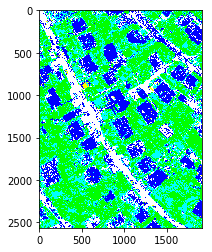

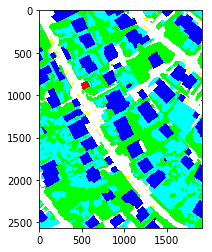

0.62523955073254323

In [79]:
#prediction for 15th area
predicted_plain_labels = clf.predict(test_data)
predicted_labels = predicted_plain_labels.copy()
predicted_labels.resize(cur_lab.shape[0],cur_lab.shape[1])
predicted_pic = convert_labels_to_color(predicted_labels)
io.imsave("Predicted labels for %d.jpg" %15, predicted_pic)
show_pic(predicted_pic)
show_pic(get_label_pic(ind))
f1_score(test_label_map, predicted_plain_labels, labels = [0,1,2,3,4,5,6], average = 'micro')